# General

## Mount Google Drive

In [1]:
from google.colab import drive #mount Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


## Imports

In [74]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
import os
import sys
import logging
import time
import h5py
import math

#### Grad-CAM
import scipy.io.wavfile as wavf
from sklearn.preprocessing import minmax_scale
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
from PIL import ImageOps
from keras.preprocessing.image import img_to_array,array_to_img

## Set Paths

In [55]:
# set root dir: the path to the github repo folder "XAI_spec_TSC" in your google drive
root_dir = '/gdrive/My Drive/XAI_spec_AudioMNIST/'

paths = {
    'root': root_dir,
    'dataset': os.path.join(root_dir,'AudioMNIST-master'),
    'data': os.path.join(root_dir,'AudioMNIST-master/data'),
    'meta': os.path.join(root_dir,'AudioMNIST-master/data/audioMNIST_meta.txt'),
    'spectrograms': os.path.join(root_dir,'spectrograms'),
    'splits': os.path.join(root_dir,'splits'),
    'results': os.path.join(root_dir, 'results'),
    'models': os.path.join(root_dir, 'results/models'),
    'history': os.path.join(root_dir, 'results/history'),
    'evaluation': os.path.join(root_dir, 'results/evaluation'),
    'xai': os.path.join(root_dir, 'results/xai'),
    'plots': os.path.join(root_dir, 'results/plots'),
    'plots_waveform': os.path.join(root_dir, 'results/plots/waveform'),
    'plots_spectrograms': os.path.join(root_dir, 'results/plots/spectrograms'),
    'plots_xai': os.path.join(root_dir, 'results/plots/xai'),
    'plots_Grad-CAM': os.path.join(root_dir, 'results/plots/xai/Grad-CAM'),
}

# labels and number of splits
labels = ['gender','digit']
splits = 5

# append the directory to the python path using sys in order to make the seperate py files importable
sys.path.append(root_dir)

## Utils

In [56]:
########## 1. function to write log about the events
def write_log(message):
    logging.basicConfig(level = logging.INFO, filename=os.path.join(root_dir,'events.log'), filemode='a', format='%(asctime)s - %(message)s')
    logging.info(message)
    print(message) 


########## 2. function to create a directory
def create_directory(directory_path):
    if os.path.isdir(directory_path) == False:
        os.mkdir(directory_path)
        write_log('Created folder: '+directory_path)
    #else:
        #writeLog('Folder already exists: '+directory_path)

########## 3. function to calculate time difference between two timepoints from package 'time' and returns the duration in format HH:MM:SS as String
def get_duration(start_time,end_time):
    duration = round(end_time-start_time)
    if duration < 0:
        duration*=-1
    h=math.floor(duration/3600)
    r=duration%3600
    m=math.floor(r/60)
    r=r%60
    s=round(r)
    return(str(h).zfill(2)+':'+str(m).zfill(2)+':'+str(s).zfill(2))

########### 4. function to read spectrograms/labels and return np.arrays ready for training/evaluation/xai methods
def read_spectrograms_hdf5(label,split_index,split_type,resize_factor=1,reshape=False,img_width=227, img_height=227, img_num_channels=1):
  write_log('Started reading '+str(split_type)+' data ...')
  start_time = time.time()
  if label == 'gender':
    label_index = 1
  else:
    label_index = 0
  # read txt with current split paths
  path_to_split_paths = os.path.join(paths['splits'],'AlexNet_'+str(label)+'_'+str(split_index)+'_'+str(split_type)+'.txt')
  text_file = open(path_to_split_paths, 'r')
  split_paths = text_file.read().split('\n')
  text_file.close()
  # if there are empty lines at the end of the txt file there will be an empty list element for each empty line
  # removing empty lines/list elements
  while split_paths[len(split_paths)-1] == '':
    split_paths.pop(len(split_paths)-1)
  # read hdf5 files of the current split and split_type and store it as np.array (spectrograms as x and labels as y)
  index = 0
  x = np.zeros(((len(split_paths),227,227))) # create target array for spectrograms
  y = np.zeros(len(split_paths)) # create target array for labels
  for cur_path in split_paths: # iterate the files
    #read current file
    f = h5py.File(cur_path, 'r')
    x_cur = f['data'][...]
    y_cur = f['label'][...]
    f.close() 
    #extract relevant data of current file
    x_cur = x_cur[0][0]
    y_cur = y_cur[0][label_index]    
    #append current data to x and y
    x[index] = x_cur
    y[index] = y_cur
    # increase index by 1
    index +=1
  x = x/resize_factor
  if reshape:
    x = x.reshape((len(x), img_width, img_height, img_num_channels))
  write_log('Finished reading '+str(split_type)+' data in '+get_duration(start_time,time.time()))
  return x,y

#create directories for the results
for path in paths:
  if 'result' in paths[path]:
    create_directory(paths[path])

Created folder: /gdrive/My Drive/XAI_spec_AudioMNIST/results/plots/xai
Created folder: /gdrive/My Drive/XAI_spec_AudioMNIST/results/plots/xai/Grad-CAM


# Waveform and spectrogram plots

In [67]:
# function creates a waveform plot for a single .wav file
# src is the path to the .wav file
# dst is the path were the plot is saved to
# optional the y-axis can be scaled between -1 and 1 (default True)
# optional the plot can be shown (default False)
def create_waveform_plot(src,dst,scale=True,show=False):
  if os.path.isfile(dst):
    return
  create_directory(os.path.join(paths['plots_waveform'],dst.split('/')[-2])) #create the subfolder with participant number, eg. 01
  fs, data = wavf.read(src)
  if scale:
    data = minmax_scale(data,feature_range=(-1,1),axis=0,copy=True) # optional: scales the y-axis between -1 and 1
  duration = len(data)/fs #duration of the file
  time_values = np.arange(0,duration,1/fs) #time vector
  # sometimes time and data dont have the same length which causes an error: fix by adjusting the length
  if len(time_values) != len(data):
    if len(time_values)>len(data):
      time_values = time_values[0:len(data)]
    else:
      data = data[0:len(time_values)]
  plt.plot(time_values,data)
  plt.xlabel('Time [s]')
  plt.ylabel('Amplitude')
  plt.savefig(dst)
  if show:
    plt.show()
  plt.close()
  return

# function creates a spectrogram plot for a single .hdf5 file - analog to the function for waveform files
def create_spectrogram_plot(cur_spectrogram_data,dst,show=False):
  if os.path.isfile(dst):
    return
  create_directory(os.path.join(paths['plots_spectrograms'],dst.split('/')[-2])) #create the subfolder with participant number, eg. 01
  # reshape data, create spectrogram image, save as png
  data = cur_spectrogram_data
  data = np.squeeze(data) # alternatively use: data = data[0,0]
  data = data.reshape(227,227,1)
  img = array_to_img(data)
  img = ImageOps.flip(img) # the picture is otherwise upside down
  img.save(dst)
  if show:
    display(img)
  return

# Grad-CAM
The Code was reimplemented from the following source:
https://keras.io/examples/vision/grad_cam/

## Functions to create a single heatmap

In [39]:
# Note: the following function is from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
# Note: the following function is from https://keras.io/examples/vision/grad_cam/
def save_and_display_gradcam(img, heatmap, dst, alpha=0.4, show=False):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img = ImageOps.flip(superimposed_img) # the picture is otherwise upside down
    # Save the superimposed image
    superimposed_img.save(dst)
    # Display Grad CAM
    if show:
      display(superimposed_img)


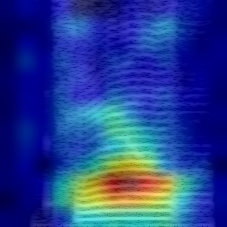

In [33]:
model = load_model(os.path.join(paths['models'],'AlexNet_gender_0.h5'))
filepath = os.path.join(paths['spectrograms'],'38/AlexNet_0_38_0.hdf5') #gender0, male: 38/AlexNet_0_38_0.hdf5 || gender0, female: 58/AlexNet_1_58_44.hdf5|| digit0: 32/AlexNet_6_32_8.hdf5
f = h5py.File(filepath, 'r')
x_cur = f['data'][...]
y_cur = f['label'][...]
f.close()
#x_cur = np.squeeze(x_cur) # alternatively use: data = data[0,0]
img = x_cur.reshape(227,227,1)
# img = array_to_img(img)
# img = ImageOps.flip(img) # the picture is otherwise upside down
# img = img_to_array(img)

x_cur = x_cur/255
x_data = x_cur.reshape(1,227,227,1)
y_data = y_cur[0][0]

last_conv_layer_name = 'conv2d_4'
# Prepare image
img_array = x_data

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
# pred_probas = model.predict(x_data, verbose=0)
# prediction = np.argmax(pred_probas,axis=1)
# print("Predicted: "+str(prediction))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(img, heatmap,show=True)

## Prepare spectrograms and call Grad-CAM functions

In [88]:
# function transforms data into the correct shape and calls the Grad-CAM functions above
def create_single_grad_cam(spectrogram_data,dst,model,show=False):
  if os.path.isfile(dst):
    return
  # TODO mkdirs from dst
  create_directory(os.path.join(paths['plots_Grad-CAM'],dst.split('/')[-3])) #create the subfolder with label and split (one is needed for each model), eg. label_gender_split_1
  create_directory(os.path.join(paths['plots_Grad-CAM'],dst.split('/')[-3],dst.split('/')[-2])) #create the subfolder with participant number, eg. 01
  # reshape image to grayscale
  img = spectrogram_data.reshape(227,227,1)
  # reshape data for model
  x_cur = spectrogram_data/255
  x_cur = x_cur.reshape(1,227,227,1)
  # define last convolutional layer
  last_conv_layer_name = 'conv2d_4'
  # Remove last layer's softmax
  model.layers[-1].activation = None
  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(x_cur, model, last_conv_layer_name)
  # Merge heatmap with original image and save result
  save_and_display_gradcam(img, heatmap,dst,show=show)

# function to read a single hdf5 spectrogram
def read_single_spectrogram_hdf5(filepath):
  f = h5py.File(filepath, 'r')
  x = f['data'][...]
  y = f['label'][...]
  f.close()
  return x,y

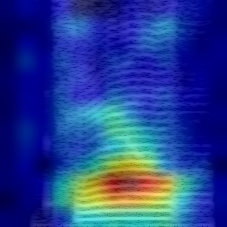

In [43]:
data,_ = read_single_spectrogram_hdf5(os.path.join(paths['spectrograms'],'38/AlexNet_0_38_0.hdf5'))
create_single_grad_cam(data,model,os.path.join(paths['root'],'graaaad.png'),show=True)

In [44]:
# read txt with current testsplit paths (txt contains paths to spectrograms)
def get_split_paths(path_to_split_paths):
  text_file = open(path_to_split_paths, 'r')
  split_paths = text_file.read().split('\n')
  text_file.close()
  # if there are empty lines at the end of the txt file there will be an empty list element for each empty line
  # removing empty lines/list elements
  while split_paths[len(split_paths)-1] == '':
    split_paths.pop(len(split_paths)-1)
  return split_paths

# Start functions

In [89]:
output_types = ['plots_waveform','plots_spectrograms','plots_Grad-CAM']
# iterate models
model_counter = 0
for model_name in os.listdir(paths['models']):
  if model_counter > 0:
    break
  model = load_model(os.path.join(paths['models'],model_name))
  net,label,split_index = model_name.rstrip(".h5").split("/")[-1].split("_")
  # set path to txt file which contains the spectrogram paths of the current test split
  path_to_split_paths = os.path.join(paths['splits'],net+'_'+str(label)+'_'+str(split_index)+'_test'+'.txt')
  # read txt
  split_paths = get_split_paths(path_to_split_paths)
  # iterate files in testsplit
  file_counter = 0
  for filepath in split_paths:
    if file_counter >0:
      break
    # infer sample info from name
    net, dig, vp, rep = path.rstrip(".hdf5").split("/")[-1].split("_")
    # set saving paths
    dst = {}
    for output_type in output_types: # for XAI methods there are different output plots for each model which makes an additional folder structure necessary
      if output_type in ['plots_waveform','plots_spectrograms']:
        additional_folder = '' # no additional folder for waveform and spectrograms
      else:
        additional_folder = 'label_'+str(label)+'_split_'+str(split_index) # additional folder (for each model) for XAI methods
      dst[output_type] = os.path.join(paths[output_type],additional_folder,str(vp),str(dig)+'_'+str(vp)+'_'+str(rep)+'.png') # set path
    # set waveform source path
    src_waveform = os.path.join(paths['data'],str(vp),str(dig)+'_'+str(vp)+'_'+str(rep)+'.wav')
    # read spectrogram from hdf5 file
    cur_spectrogram_data,_ = read_one_spectrogram_hdf5(filepath)
    # call functions to create outputs
    create_waveform_plot(src_waveform,dst['plots_waveform'],scale=True,show=False)
    create_spectrogram_plot(cur_spectrogram_data,dst['plots_spectrograms'],show=False)
    create_single_grad_cam(cur_spectrogram_data,dst['plots_Grad-CAM'],model,show=False)
    file_counter +=1
  model_counter +=1

Created folder: /gdrive/My Drive/XAI_spec_AudioMNIST/results/plots/xai/Grad-CAM/label_gender_split_0/58


# innvestigate

In [ ]:
pip install innvestigate --ignore-installed

In [ ]:
import innvestigate
import keras
import tensorflow

In [ ]:
print(innvestigate.__version__)
print(keras.__version__)
print(tensorflow.__version__)

# DeepExplain

In [ ]:
pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

#Grad-CAM

In [9]:
#imports
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image,ImageOps
from keras.preprocessing.image import img_to_array,array_to_img

In [11]:
model = load_model(os.path.join(paths['models'],'AlexNet_digit_0.h5'))
filepath = '/gdrive/My Drive/Xplainable AI - Univariate Time Series - spectrograms/spectrograms/32/AlexNet_0_32_1.hdf5'
f = h5py.File(filepath, 'r')
x_cur = f['data'][...]
y_cur = f['label'][...]
f.close() 
img = x_cur.reshape(227,227,1)
x_cur = x_cur/255
x_cur = x_cur.reshape(227,227,1)

# read according test data
#x_test, y_test = read_data('digit',0,'test')
# Reshape data, must be (no_spectrograms, 227,227,1) instead of (no_spectrograms, 227,227)
#x_test_reshaped = x_test.reshape((len(x_test), 227,227,1))

last_layer = 'conv2d_4'
#pred_probas = model.predict(x_cur, verbose=1)
#predictions = np.argmax(pred_probas,axis=1)
# img = array_to_img(img)
# display(img)

In [12]:
# from https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image,ImageOps
from keras.preprocessing.image import img_to_array,array_to_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


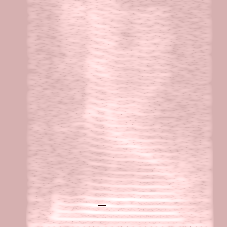

In [15]:


#IMAGE_PATH = './cat.jpg'
LAYER_NAME = last_layer
CAT_CLASS_INDEX = 0

#img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
#img = tf.keras.preprocessing.image.img_to_array(img)

#model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([x_cur]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (227, 227))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)



output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 1, cam, 0.3, 0)
output_image = cv2.flip(output_image, 0)
cv2.imwrite(os.path.join(paths['root'],'gradCAM.png'), output_image)
res = array_to_img(output_image)
display(res)

In [ ]:
# get last layer name
for model_name in os.listdir(paths['models']):
  # get layer name of last conv layer
  model = load_model(os.path.join(paths['models'],model_name))
  last_layer = model.layers[10].name #conv2d_4
  print(last_layer)

# Grad-CAM last semester

In [8]:
pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 3.2 MB/s 
     |████████████████████████████████| 15.7 MB 409 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.2 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but

In [6]:
import cv2
from tensorflow.keras import backend as K

In [7]:
model = load_model(os.path.join(paths['models'],'AlexNet_digit_0.h5'))
filepath = '/gdrive/My Drive/Xplainable AI - Univariate Time Series - spectrograms/spectrograms/32/AlexNet_6_32_8.hdf5'
f = h5py.File(filepath, 'r')
x_cur = f['data'][...]
y_cur = f['label'][...]
f.close()
img = x_cur.reshape(227,227,1)
x_cur = x_cur/255
x_data = x_cur.reshape(1,227,227,1)
y_data = y_cur[0][0]

TypeError: ignored

In [ ]:
pred_probas = model.predict(x_data, verbose=1)
predictions = np.argmax(pred_probas,axis=1)
print('Predicted: '+str(predictions)+' Actual: '+str(y_data))

In [44]:
#whole cell is new, for tensorflow version 1.15
def getHeatMap(inp_img, class_idx, last_layer):
    #Get the output tensor from the model and get the last convlayer from model
    with tf.device('/gpu:0'):
        miss = model.output[class_idx]
        last_conv_layer = model.get_layer(last_layer)

        #Calculate gradient of output with respect to output of last convlayer
        grads = K.gradients(miss, last_conv_layer.output)[0]

        #Pool the gradients over all channels 
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

        #Function returns the values of the pooled grads and the output value of the layers
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

        # Run function to the values for x
        pooled_grads_value, conv_layer_output_value = iterate([inp_img])
    
    for i in range(len(pooled_grads_value)):
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

In [45]:
#create folder
outHeatmaps = os.path.join(paths['xai'],'Grad-CAM')
#os.makedirs(outHeatmaps)

#check if heatmaps are already created and stored
lsFiles = os.listdir(outHeatmaps) #glob.glob(outHeatmaps + '/**/*.png', recursive=True)
if not lsFiles:

  # Settings for cv2 puttext
  font = cv2.FONT_HERSHEY_SIMPLEX

  # More settings for cv2
  fontScale = 1
  fontColor = (0,0,0)
  lineType = 2




  # Select the image you want to output the heatmap for
  for idx in range(0,1): #welches Bild aus unserem Bildarray wollen wir nehmen
    print(idx)
    # Define the last layer in the model
    last_layer = 'conv2d_4'

    #Convert the labels into integers
    yt = np.uint8(y_data) # label wird quasi umgewandelt

    # Expand the dimensionality so it fits to the Keras scheme
    #x = np.expand_dims(x_data[idx],axis=0)# für Bild 1 in diesem Fall

    # Get the heatmaps for the selected image 
    # In case you have a binary output with sigmoid always use 0 as class_index
    heatmap_val_org = getHeatMap(x_data, 0, last_layer) # die 0 ist besonderheit, wenn binär mit Sigmoid dann 0, mehr-Klassen-Problem mit softmax das unten verwenden

    #For multi-class with softmax use this
    heatmap_val_org = getHeatMap(x, yt, last_layer)

    heatmap_val = heatmap_val_org.copy()

    # Color the valence heatmap and combine it with the image 
    # The heatmaps are resized to the size of x_batch (299x299)
    heatmap_val = np.uint8(heatmap_val * (255)) #-127.5
    heatmap_val = cv2.resize(heatmap_val, (x.shape[2], x.shape[1]))
    heatmap_val = cv2.applyColorMap(heatmap_val, cv2.COLORMAP_JET)
    super_img_val = heatmap_val * 0.4 + np.uint8(x_data[idx] / (1./255)) #-127.5# Reverse the scaling of the ImageDataGenerator, #0.4 deckeungsstärkestärke der Heatmap

    plt.imshow(np.uint(super_img_val))
    cv2.imwrite(outHeatmaps + 'heatmap{0}_class_{1}.png'.format(str(idx), str(yt)), super_img_val)
else:
  print("Heatmaps already there")

0


TypeError: ignored

In [30]:
np.expand_dims(x_data,axis=0).shape

(1, 1, 227, 227, 1)